# Geological model of Okarapehoui/ Nigeria

Here another test case to create a geological model directly from GoogleEarth - completely work in progress, so beware...

However, this notebook is focused on describing the method to *new* regions of interest - in addition to the Jebel Madar Dome example of the Paper.

<img src="../figures/Namibia_Okauapehuri_perspective_view.png" width="600"/>



In [107]:
import sys, warnings, numpy as np, matplotlib.pyplot as plt, gdal
sys.path.append(r"..")
import rgeomod
warnings.filterwarnings('ignore')
sys.path.append("../../gempy")
import gempy as gp
import mplstereonet
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Determine model extent and obtain DTM

As a first step, we determine the model extent this time directly from a path element in GoogleEarth.

Here is an example for this model:

<img src="../figures/Namibia_Okauapehuri_extent.png" width="600"/>

As before, simply save this path to a `.kml` file. We now extract the coordinates from this path and determine min/max extent in each direction. To load the path:


In [108]:
extent = rgeomod.KmlPoints()

In [109]:
extent.read_kml("../data/Okauapehuri_model_extent.kml")

Here are the points of this line:

In [110]:
extent.point_sets[0].points

[p(13.877884, -17.546278) in latlong,
 p(13.882548, -17.523018) in latlong,
 p(13.928292, -17.520992) in latlong,
 p(13.974078, -17.544019) in latlong,
 p(13.976560, -17.565886) in latlong,
 p(13.968418, -17.589864) in latlong,
 p(13.907763, -17.570623) in latlong,
 p(13.890192, -17.559879) in latlong,
 p(13.877884, -17.546278) in latlong]

Get minimum and maximum values:

In [111]:
extent.point_sets[0].minmax()
print(extent.point_sets[0].min)
print(extent.point_sets[0].max)

[ 13.87788449 -17.58986435]
[ 13.97655956 -17.52099218]


Round to 3 digits:

In [112]:
xmin, ymin = np.round(extent.point_sets[0].min, decimals=3)
xmax, ymax = np.round(extent.point_sets[0].max, decimals=3)

In [113]:
xmin, ymin, xmax, ymax

(13.878, -17.59, 13.977, -17.521)

Save points in point object (for simpler use below):

In [114]:
ex_min = rgeomod.Point(x=xmin, y=ymin, type='latlong')
ex_max = rgeomod.Point(x=xmax, y=ymax, type='latlong')

## Get elevation data

As we described in the paper and the previous notebooks, DTM elevation data can be obtained from a variety of online sources and repositories. Luckily, there is also a nice Python project which makes downloading this data quite simple.

The project is available on: https://github.com/bopen/elevation

<div class="alert alert-warning">
**To do:** Include package and methods directly into rgeomod!
</div>

After standard installation (pip install elevation), it can be imported and used to download the DTM data for our region of interest:

In [115]:
import elevation

In [116]:
# clip the SRTM1 30m DEM of Rome and save it to Rome-DEM.tif
elevation.clip(bounds=(xmin, ymin, xmax, ymax), 
               output='/Users/flow/git/remote-geomod/projects/Nambia_Okauapehoui/Namibia.tif')

# clean up stale temporary files and fix the cache in the event of a server error
elevation.clean()

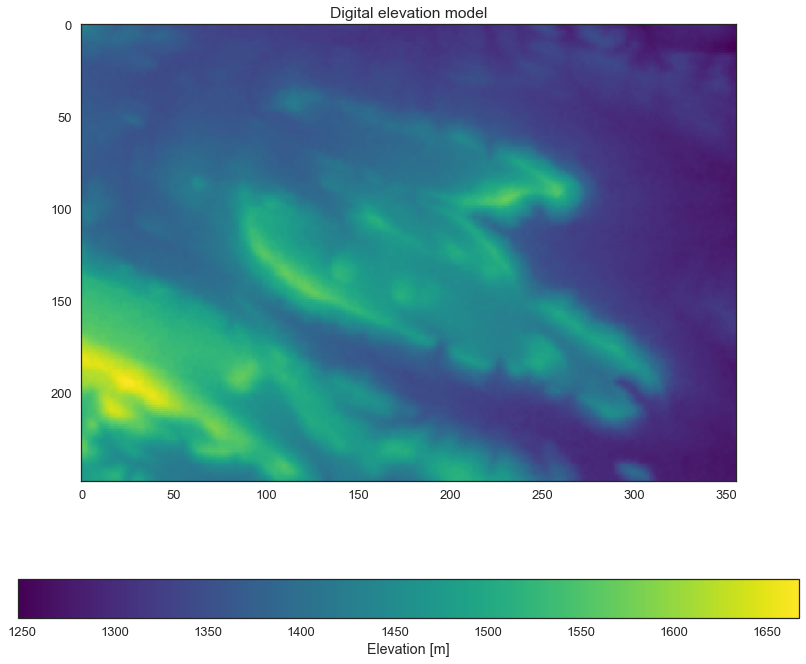

In [117]:
# load the digital elevation model
geotiff_filepath = "../projects/Nambia_Okauapehoui/Namibia.tif"
raster = gdal.Open(geotiff_filepath)
dtm = raster.ReadAsArray()
plt.figure(figsize=(14,12))
dtmp = plt.imshow(dtm, origin='upper', cmap="viridis");
plt.title("Digital elevation model");
plt.colorbar(dtmp, label="Elevation [m]", orientation='horizontal');
plt.savefig("../projects/Nambia_Okauapehoui/DTM_Namibia.pdf")

## Process input data

We now follow the same steps as in the introduction notebook: load picked points and process orientation data:

In [118]:
folder_path = "../projects/Nambia_Okauapehoui/"
point_sets, formation_names, ps_bool, fn = rgeomod.read_kml_files(folder_path)

read kml
9 point sets added
01_Unit1_dips.kml


read kml
2 point sets added
02_Unit2_.kml


read kml
1 point sets added
01_Unit1_.kml




In [119]:
formation_names

['Unit1', 'Unit2', 'Unit1']

In [120]:
# Add elevation values:
# set the path to the geotiff file:
geotiff_filepath = "../projects/Nambia_Okauapehoui/Namibia.tif"

rgeomod.get_elevation_from_dtm(point_sets, geotiff_filepath)

Extracting elevation data: 100%|██████████| 3/3 [00:00<00:00,  3.15it/s]

Elevation data successfully extracted from DTM.


### Fit planes to points

Note: this step requires suitable UTM transformation codes! If you get an error, please see:

http://spatialreference.org/ref/epsg/

In [121]:
rgeomod.fit_planes_to_points(point_sets)

Fitting planes to point sets: 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]

Planes successfully fit to point sets.


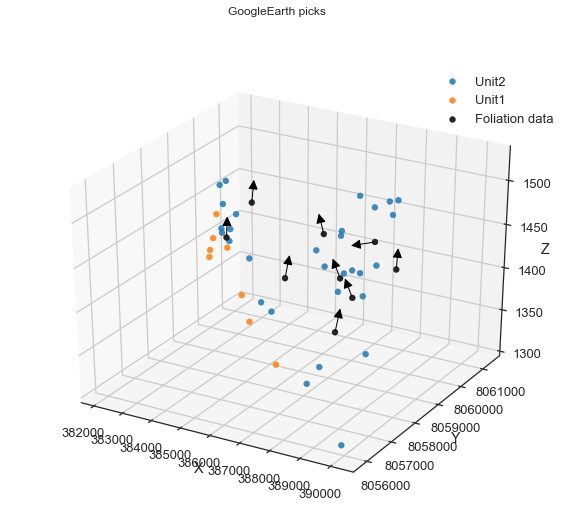

In [122]:
interfaces, foliations = rgeomod.convert_to_df(point_sets, formation_names, fn, ps_bool)
rgeomod.plot_input_data_3d_scatter(interfaces, foliations)

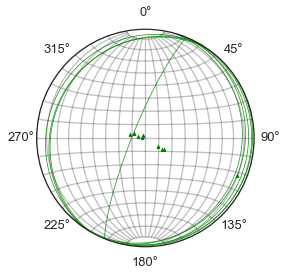

In [123]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='stereonet')
ax.pole(foliations["azimuth"], foliations["dip"], 'g^', markersize=4)
ax.plane(foliations["azimuth"], foliations["dip"], 'g-', linewidth=0.75, alpha=0.85)
ax.grid(True, color="black", alpha=0.25)

### Save data for further use

In [124]:
interfaces.to_csv("../projects/Nambia_Okauapehoui/gempy_interfaces.csv", index=False)
foliations.to_csv("../projects/Nambia_Okauapehoui/gempy_foliations.csv", index=False)

## Set up model and load data

Just as before, we now set up the model and load back the foliation information.

(NOTE as todo: load data directly in memory - to avoid IO overhead)

We need to work on a projection now, so we use the model extent given by the UTM coordinates.

In [125]:
# convert extent points to UTM:
ex_min.latlong_to_utm()
ex_max.latlong_to_utm()
ex_min.x, ex_max.x, ex_min.y, ex_max.y

(380944.4141053709, 391409.1614859635, 8054822.000012236, 8062515.9853901975)

In [126]:
# get maximum of elevation and round up to next 100:
z_max = np.ceil((np.max(dtm)/100))*100
# vertical extent: simply 2000 meters here:
z_min = z_max - 2000.

In [127]:
geo_data=gp.create_data(extent=[ex_min.x, ex_max.x, ex_min.y, ex_max.y, z_min, z_max], 
                        resolution=[50, 50, 50],
                        path_f = "../projects/Nambia_Okauapehoui/gempy_foliations.csv",
                        path_i = "../projects/Nambia_Okauapehoui/gempy_interfaces.csv")

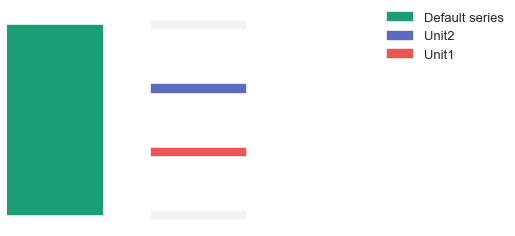

In [128]:
formation_order = ["Unit2", "Unit1"]
gp.set_series(geo_data, {"Default series": formation_order},
             order_formations = formation_order)
# gp.plot_data(geo_data, direction="z")

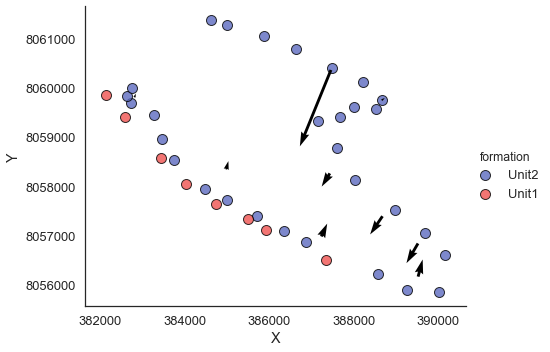

In [129]:
gp.plot_data(geo_data, direction="z")

In [130]:
# try:
#     gp.plot_data_3D(geo_data)
# except NameError:
#     print("3-D visualization library vtk not installed.")

In [131]:
geo_data.interfaces.head()

,X,Y,Z,formation,series,formation number,order_series,isFault,annotations
0,388568.603031,8.056235e+06,1360.0,Unit2,Default series,1,1,False,"${\bf{x}}_{\alpha \,{\bf{1}},0}$"
1,383735.933880,8.058531e+06,1503.0,Unit2,Default series,1,1,False,"${\bf{x}}_{\alpha \,{\bf{1}},1}$"
2,383268.119782,8.059437e+06,1433.0,Unit2,Default series,1,1,False,"${\bf{x}}_{\alpha \,{\bf{1}},2}$"
3,382723.691808,8.059698e+06,1425.0,Unit2,Default series,1,1,False,"${\bf{x}}_{\alpha \,{\bf{1}},3}$"
4,382635.266962,8.059823e+06,1417.0,Unit2,Default series,1,1,False,"${\bf{x}}_{\alpha \,{\bf{1}},4}$"


In [132]:
interp_data = gp.InterpolatorInput(geo_data, dtype="float64", u_grade=[3])

Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64


In [133]:
lith_block, fault_block = gp.compute_model(interp_data)
print("3-D geological model calculated.")

3-D geological model calculated.


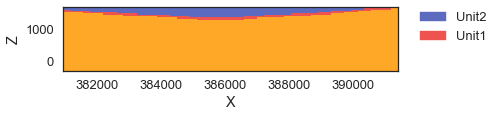

In [134]:
gp.plot_section(geo_data, lith_block[0], 25, direction='y', plot_data=False)
plt.savefig("../projects/Nambia_Okauapehoui/cross_section_NS_25.pdf", bbox_inches="tight")

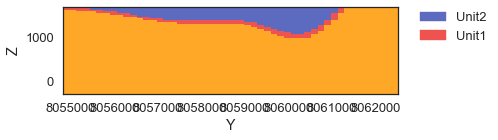

In [135]:
gp.plot_section(geo_data, lith_block[0], 25, direction='x', plot_data=False)
plt.savefig("../data/cross_section_EW_25.pdf", bbox_inches="tight")

In [137]:
vertices, simplices = gp.get_surfaces(interp_data, potential_lith=lith_block[1], step_size=2)
try:
    gp.plot_surfaces_3D(geo_data, vertices, simplices)
except NameError:
    print("3-D visualization library vtk not installed.")

## Create geological map

We now repeat the same steps as in the example notebook to create the geological map from the generated model. We already have the DTM loaded (see beginning of this notebook) and now simply have to calculate the model intersection:

In [139]:
# get resolution of dtm
dtm.shape

(248, 356)

In [140]:
# convert the dtm to a gempy-suitable raveled grid
points = rgeomod.convert_dtm_to_gempy_grid(raster, dtm)

# Note: points have to be converted to UTM - *very* inefficient implementation for now...
points_utm = []
for p in points:
    p_tmp = rgeomod.Point(x=p[0], y=p[1], z=p[2], type='latlong')
    p_tmp.latlong_to_utm()
    points_utm.append((p_tmp.x, p_tmp.y, p_tmp.z))

points_utm = np.array(points_utm)

In [173]:
geo_data_geomap = gp.create_data(extent=[ex_min.x, ex_max.x, ex_min.y, ex_max.y, z_min, z_max], 
                        resolution=[dtm.shape[1], dtm.shape[0], 1],
                        path_f = "../projects/Nambia_Okauapehoui/gempy_foliations.csv",
                        path_i = "../projects/Nambia_Okauapehoui/gempy_interfaces.csv")

gp.set_series(geo_data_geomap, {"Default series": formation_order},
             order_formations = formation_order, verbose=0)

#NReplace grid points with DTM grid points:
geo_data.grid.grid = points_utm

In [174]:
interp_data_geomap = gp.InterpolatorInput(geo_data, dtype="float64")
lith_block, fault_block = gp.compute_model(interp_data_geomap)

Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64


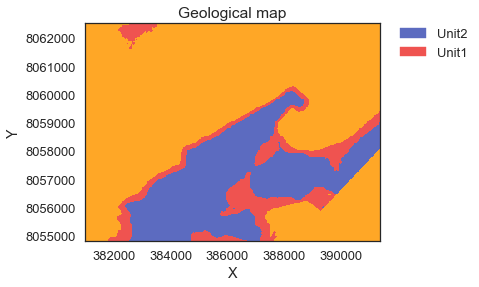

In [175]:
gp.plot_section(geo_data_geomap, lith_block[0], 0, direction='z', plot_data=False)
plt.title("Geological map");
plt.savefig("../projects/Nambia_Okauapehoui/geological_map.png")

In [178]:
geo_map = lith_block[0].copy().reshape((dtm.shape[1],dtm.shape[0]))
geo_map = geo_map.astype('int16')  # change to int for later use

In [179]:
rgeomod.export_geotiff("../projects/Nambia_Okauapehoui/geomap.tif", geo_map, gp.colors.cmap, geotiff_filepath)

Successfully exported geological map to ../projects/Nambia_Okauapehoui/geomap.tif


In [180]:
# export picked points for vis in GoogleEarth:
t = "../rgeomod/templates/ge_template_raw_interf.xml"
pt = "../rgeomod/templates/ge_placemark_template_interf.xml"
rgeomod.gempy_export_points_to_kml("../projects/Nambia_Okauapehoui/", geo_data, pt, t, gp.colors.cmap)


In [181]:
t = "../rgeomod/templates/ge_template_raw_fol.xml"
pt = "../rgeomod/templates/ge_placemark_template_fol.xml"
rgeomod.gempy_export_fol_to_kml("../projects/Nambia_Okauapehoui/dips.kml", geo_data, pt, t)